# Lab 2-3: Monte Carlo Tests & Generating Random Numbers from a Given Probability Distribution

Given any distribution for which we have a CDF available as a closed form expression, or simple lookup table, we can use the following approach to generate random numbers from that distribution.

A basic approach for generating a sample of n random numbers from a desired probability distribution:

1. Generate n random numbers from a uniform distribution on the interval [0,1]. (e.g. by using `np.random.uniform`) Recall that a CDF always ranges from 0 to 1 for a set of numbers, this first set of numbers we've generated from a uniform distribution are quantile values.

2. Map the quantile values we just generated to the quantile value from the CDF of the desired distribution. (e.g. as a lookup table, or with a function like [`np.quantile`](https://numpy.org/doc/stable/reference/generated/numpy.quantile.html#numpy.quantile))

---

Start by importing the python libraries we'll need, and load our data file for the Skykomish river annual peak flow values.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
skykomish_data_file = 'Skykomish_peak_flow_12134500_skykomish_river_near_gold_bar.xlsx'
skykomish_data = pd.read_excel(skykomish_data_file)
# preview the dataframe
skykomish_data.head(3)

,date of peak,water year,peak value (cfs),gage_ht (feet)
0,1928-10-09,1929,18800,10.55
1,1930-02-05,1930,15800,10.44
2,1931-01-28,1931,35100,14.08


Divide the data into the early period (before 1975) and late period (after and including 1975).

In [3]:
skykomish_before = skykomish_data[ skykomish_data['water year'] < 1975 ] 
skykomish_after = skykomish_data[ skykomish_data['water year'] >= 1975 ] 

Define our cunnane plotting functions that work with our pandas dataframes, or generic 1d numpy arrays or lists.

In [4]:
### Method 1
# This function requires that the input is a pandas dataframe, with column names, and an integer index
# It returns a copy of the dataframe with an extra column added that has the Cunnane plotting positions
def cunnane_quantile(df, column_name):
    '''This function will compute the Cunnane plotting position for the values in a column of a dataframe.
    It requres a pandas dataframe, and the column name of interest (a text string) as inputs.
    The output is a new dataframe, ranked (sorted) with an extra column with the plotting position.
    [Steven Pestana, spestana@uw.edu, Oct. 2020]'''
    
    # Rank all our values
    ranked_df = df.sort_values(by=[column_name]).reset_index()
    
    # Calculate the Cunnane plotting position
    ranked_df['cunnane_plotting_position'] = ((ranked_df.index + 1) - (2/5)) / (ranked_df[column_name].count() + (1/5))
        
    return ranked_df

### Method 2
# This function should be able to accept any one-dimensional numpy array or list, of numbers
# It returns two numpy arrays, one of the sorted numbers, the other of the plotting position
def cunnane_quantile_array(numbers):
    '''This function also computes the Cunnane plotting position given an array or list of numbers (rather than a pandas dataframe).
    It has two outputs, first the sorted numbers, second the Cunnane plotting position for each of those numbers.
    [Steven Pestana, spestana@uw.edu, Oct. 2020]'''
    
    # 1) sort the data, using the numpy sort function (np.sort())
    sorted_numbers = np.sort(numbers)
    
    # length of the list of numbers
    n = len(sorted_numbers) 
    
    # make an empty array, of the same length. below we will add the plotting position values to this array
    cunnane_plotting_position = np.empty(n)
    
    # 2) compute the Cunnane plotting position for each number, using a for loop and the enumerate function
    for rank, number in enumerate(sorted_numbers):
        cunnane_plotting_position[rank] = ( (rank+1) - (2/5) ) / ( n + (1/5) )
    
    return sorted_numbers, cunnane_plotting_position

Create the empirical CDFs with the Cunnane plotting position for our before and after 1975 datasets.

In [5]:
# Use the cunnane quantile function for before 1975
skykomish_before_b = cunnane_quantile(skykomish_before, 'peak value (cfs)')

# Use the cunnane quantile function for after 1975
skykomish_after_a = cunnane_quantile(skykomish_after, 'peak value (cfs)')

Plot the CDFs together.

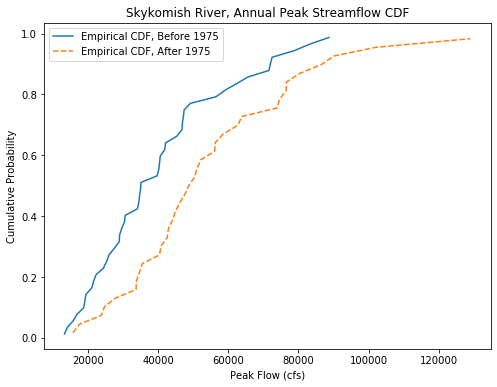

In [6]:
fig, ax = plt.subplots(figsize=(8,6))

# Empirical CDF, Before 1975
ax.plot(skykomish_before_b['peak value (cfs)'], skykomish_before_b['cunnane_plotting_position'], 
        color='tab:blue', linestyle='-', label='Empirical CDF, Before 1975')

# Empirical CDF, After 1975
ax.plot(skykomish_after_a['peak value (cfs)'], skykomish_after_a['cunnane_plotting_position'], 
        color='tab:orange', linestyle='--', label='Empirical CDF, After 1975')

# Add legend and labels
ax.legend()
ax.set_ylabel('Cumulative Probability')
ax.set_xlabel('Peak Flow (cfs)')
ax.set_title('Skykomish River, Annual Peak Streamflow CDF');

---

**Step 1**: Generate n random numbers from a uniform distribution on the interval [0,1]. (e.g. by using `np.random.uniform`). These are quantile values.

In [7]:
# we want to use the same size size, or length, of the peak flow dataset before 1975
size = len(skykomish_before_b['peak value (cfs)']) 

# generate the random quantile values
random_quantiles = np.random.uniform(0,1,size)

**Step 2**: Map the randomly generated quantile values to the quantile values from the empirical CDF of the "before 1975" data. We can use [`np.quantile`](https://numpy.org/doc/stable/reference/generated/numpy.quantile.html#numpy.quantile) here.

This generates new "peak flow" values, drawn from the empirical CDF.

In [8]:
random_peak_flows = np.quantile(skykomish_before['peak value (cfs)'].values, random_quantiles)

Now make a CDF from our generated random peak flow data.

In [9]:
random_peak_flows_sorted, random_peak_flows_quantiles = cunnane_quantile_array(random_peak_flows)

We can plot the results to visualize what we just did:

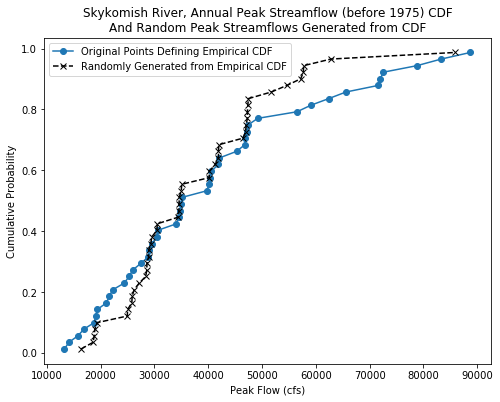

In [10]:
fig, ax = plt.subplots(figsize=(8,6))

# Empirical CDF, Before 1975
ax.plot(skykomish_before_b['peak value (cfs)'], skykomish_before_b['cunnane_plotting_position'], 
        color='tab:blue', linestyle='-', marker='o', label='Original Points Defining Empirical CDF')


ax.plot(random_peak_flows_sorted,random_peak_flows_quantiles,'kx--', label='Randomly Generated from Empirical CDF')

# Add legend and labels
ax.legend()
ax.set_ylabel('Cumulative Probability')
ax.set_xlabel('Peak Flow (cfs)')
ax.set_title('Skykomish River, Annual Peak Streamflow (before 1975) CDF\nAnd Random Peak Streamflows Generated from CDF');

We can also plot the original histogram of the beofre 1975 data, and our randomly generated values from the CDF:

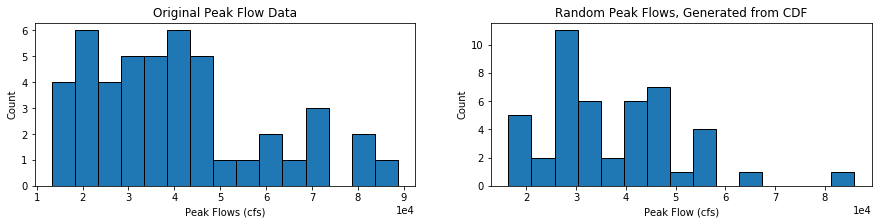

In [11]:
# Plot histograms

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(15,3))
nbins = 15

ax1.hist(skykomish_before_b['peak value (cfs)'].values, nbins, ec="black")
ax1.set_title('Original Peak Flow Data')
ax1.set_xlabel('Peak Flows (cfs)')
ax1.set_ylabel('Count')
ax1.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
                                                  
                                                       
ax2.hist(random_peak_flows, nbins, ec="black")
ax2.set_title('Random Peak Flows, Generated from CDF')
ax2.set_xlabel('Peak Flow (cfs)')
ax2.set_ylabel('Count')
ax2.ticklabel_format(axis='x', style='sci', scilimits=(0,0))


How do the shapes of the two distributions compare?

What are the mean and standard deviation of these two samples (the original sample, and our randomly generated sample)?

In [12]:
original_sample_mean = skykomish_before_b['peak value (cfs)'].mean()
original_sample_std = skykomish_before_b['peak value (cfs)'].std()
print("Original sample:\n\tmean = {m}\n\tstd = {s}".format(m=np.round(original_sample_mean,0), s=np.round(original_sample_std,0)))

generated_sample_mean = random_peak_flows.mean()
generated_sample_std = random_peak_flows.std()
print("\nGenerated sample:\n\tmean = {m}\n\tstd = {s}".format(m=np.round(generated_sample_mean,0), s=np.round(generated_sample_std,0)))

Original sample:
	mean = 40124.0
	std = 19582.0

Generated sample:
	mean = 37476.0
	std = 13771.0



---

## Monte Carlo Tests

We can use these steps to generate 100s of random samples from the empirical CDF. This is like pretending that we have many more measurements than were actually taken. By looking at a large collection of random samples from the empirical CDF, we can then compare their mean and standard deviation to that of the after-1975 period, to determine the liklihood that the after-1975 peak flow values could have come from the same underlying "true" distribution.

Generate 500 random samples (repeat Step 1 500 times). **Step 1**: Generate n random numbers from a uniform distribution on the interval [0,1]. (e.g. by using `np.random.uniform`). These are quantile values. Use n = the length of the after-1975 dataset, and assume they come from the Empirical CDF of the pre-1975 dataset.

In [13]:
# we want to use the same size size, or length, of the peak flow dataset after 1975,
# but we also want to generate this 500 times, so we can specify that we want a 2D "size" of (x, y)
# where x is the length of the dataset, and y is the number of times we want to make a new sample
size = (len(skykomish_after_a['peak value (cfs)']), 500)

# generate the random quantile values
random_quantiles = np.random.uniform(0,1,size)

# we can see the shape of the array we just made is 35 randomly generated numbers, 500 times
random_quantiles.shape

(35, 500)

(Repeat 500 times) **Step 2**: Map the randomly generated quantile values to the quantile values from the empirical CDF of the "before 1975" data. We can use [`np.quantile`](https://numpy.org/doc/stable/reference/generated/numpy.quantile.html#numpy.quantile) here. This generates new "peak flow" values, drawn from the empirical CDF.

Then also create a new CDF for each of the 500 samples.

In [14]:
# Create empty placeholder arraya of the same shape as the random quantiles
random_peak_flows = np.empty(random_quantiles.shape)
random_peak_flows_sorted = np.empty(random_quantiles.shape)
random_peak_flows_quantiles = np.empty(random_quantiles.shape)

# For each of the 500 samples...
for i in range(random_quantiles.shape[1]):
    random_peak_flows[:,i] = np.quantile(skykomish_before['peak value (cfs)'].values, random_quantiles[:,i])
    random_peak_flows_sorted[:,i], random_peak_flows_quantiles[:,i] = cunnane_quantile_array(random_peak_flows[:,i])

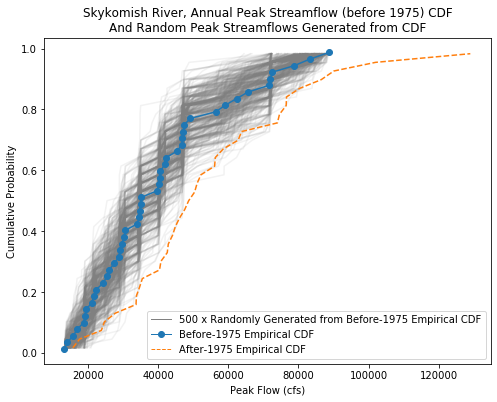

In [15]:
fig, ax = plt.subplots(figsize=(8,6))

# All the randomly generated samples
plt.plot(random_peak_flows_sorted,random_peak_flows_quantiles, alpha=0.1, color='grey');

# Empirical CDF, Before 1975
ax.plot(skykomish_before_b['peak value (cfs)'], skykomish_before_b['cunnane_plotting_position'], 
        color='tab:blue', linestyle='-', marker='o')

# Empirical CDF, After 1975
ax.plot(skykomish_after_a['peak value (cfs)'], skykomish_after_a['cunnane_plotting_position'], 
        color='tab:orange', linestyle='--', label='Empirical CDF, After 1975')


# Add custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='grey', lw=1, label='500 x Randomly Generated from Before-1975 Empirical CDF'),
                   Line2D([0], [0], color='tab:blue', lw=1, linestyle='-', marker='o', label='Before-1975 Empirical CDF'),
                   Line2D([0], [0], color='tab:orange', linestyle='--', lw=1, label='After-1975 Empirical CDF'),]

# Create the figure
ax.legend(handles=legend_elements, loc='lower right')

# Add labels
ax.set_ylabel('Cumulative Probability')
ax.set_xlabel('Peak Flow (cfs)')
ax.set_title('Skykomish River, Annual Peak Streamflow (before 1975) CDF\nAnd Random Peak Streamflows Generated from CDF');

In other words, we're interested in knowing how likely that the After-1975 sample came from the same distribution as the Before-1975 sample. We can use our randomly generated samples to represent the range of expected means values we'd get from a sample that matches the Before-1975 CDF. 

(Does our orange line CDF, after-1975 come from the same underlying population CDF as represented by the blue line before-1975, and grey line random samples?)

Compute the means and standard deviations of each of the 500 random samples:

In [16]:
# Using the numpy.mean and numpy.std functions, we can specify which axis we want to compute the mean and standard deviation along. 
# Here we choose the 0th axis, so that we compute across each of the 500 "rows" of data, which should leave us with 500 values
random_peak_flows_means = random_peak_flows.mean(axis=0)
random_peak_flows_stds = random_peak_flows.std(axis=0)

### Testing for a change in the mean

Now, using all these means, determine the mean peak flow value above which only 5% of a random set of numbers from the basic distribution would fall into.

* Take the 500 values we just calculated, and use the Cunnane-quantile method to plot them on a CDF.
* Then, look up what mean value corresponds to the 0.95 value on the CDF.
* Finally, see how the mean of the After-1975 period compares to the 0.95 quantile value.


In [17]:
# Create a CDF of our means
random_peak_flows_means_sorted, random_peak_flows_means_quantiles = cunnane_quantile_array(random_peak_flows_means)

# Find the 95% quantile value
q95 = np.quantile(random_peak_flows_means_sorted, 0.95)

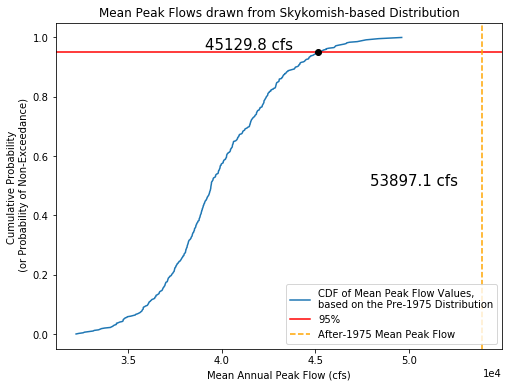

In [18]:
# Create a CDF plot
fig, ax = plt.subplots(figsize=(8,6))

# CDF of means from randomly generated samples
ax.plot(random_peak_flows_means_sorted, random_peak_flows_means_quantiles, 
        color='tab:blue', linestyle='-', label='CDF of Mean Peak Flow Values,\nbased on the Pre-1975 Distribution')

# Plot a line at the 95% value
ax.axhline(0.95,color='red',label='95%')
ax.plot(q95,0.95,linestyle='none',marker='o',color='k')
ax.text(q95-6000, 0.96, '{} cfs'.format(np.round(q95,1)), fontsize=15, color='k')

# Plot a line at the mean of the After-1975 value, is it higher or lower than the 95% quantile?
ax.axvline(skykomish_after_a['peak value (cfs)'].mean(),color='orange',linestyle='--',label='After-1975 Mean Peak Flow')
ax.text(skykomish_after_a['peak value (cfs)'].mean()-6000, 0.5, '{} cfs'.format(np.round(skykomish_after_a['peak value (cfs)'].mean(),1)), fontsize=15, color='k')

ax.set_xlabel('Mean Annual Peak Flow (cfs)')
ax.set_ylabel('Cumulative Probability \n (or Probability of Non-Exceedance)')
ax.set_title('Mean Peak Flows drawn from Skykomish-based Distribution')
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax.legend(loc='lower right');

**What does this say about the annual peak flows of the After-1975 period and how it compares to the Before-1975 period?**

By repeatedly generating samples from our empirical CDF, we are creating new datasets that are "realistic" in that they are values we *could* have reasonably measured.

When we look at these 500 sets of numbers, we can see that there is only a 5% chance that the mean of 35 numbers drawn randomly from this specific distribution would be greater than ~45000 cfs.

Therefore, if we had 35 observed values and calculated their mean, we would be 95% confident that a mean of this value or larger actually came from a different population distribution (with a larger mean than that of our original population distribution).

---